In [1]:
from __future__ import print_function

import os
import numpy as np

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from model import Loop

from sklearn.manifold import TSNE

import pandas as pd

In [2]:
os.chdir('/home/ubuntu/loop')
vctk_folder = '/home/ubuntu/VCTK-Corpus/'

In [3]:
def get_vtck_speaker_info():
    # this is the reference data file that comes as part of VCTK
    speaker_info_file = os.path.join(vctk_folder, 'speaker-info.txt')

   # read file contents
    f = open(speaker_info_file, 'r')
    x = f.readlines()
    f.close()

    # extract column headers
    cols = x[0].lower().split()
    num_cols = len(cols)
    del x[0]
    num_speaker = len(x)

    # parse the data line by line
    d = dict()

    for idx in range(num_speaker):
        this_speaker_id = int(x[idx][:3])
        this_age = int(x[idx][5:7])
        this_gender = x[idx][9]
        residual = x[idx][14:].split()
        this_accent = residual[0]
        this_region = " ".join(residual[1:])

        # add speakers to a dictionary
        d[this_speaker_id] = (this_speaker_id, this_age, this_gender, this_accent, this_region)

    # convert to Pandas datafrae
    speaker_info = pd.DataFrame.from_dict(d, orient='index', columns=cols)
    
    return speaker_info

In [4]:
# Lookup dict from VCTK speaker IDs to the IDs used inside VoiceLoop
# should really pick this up from the checkpoints, but it's convenient to have it available before/without a checkpoint being defined
speaker_list_vctk = [294, 297, 299, 300, 301, 305, 306, 308, 310, 311, 318, 329, 330, 333, 334, 339, 341, 345, 360, 361, 362]
speaker_lookup = dict([(x, y) for x, y in enumerate(speaker_list_vctk)])

# load VCTK speaker_info metadata
speaker_info = get_vtck_speaker_info()
#speaker_info[speaker_info.id.isin(speaker_lookup.values())]
tmp = pd.DataFrame.from_dict(speaker_lookup, orient='index', columns=['id'])
speaker_info_loop = pd.merge(speaker_info, tmp)

In [5]:
len(speaker_list_vctk)

21

In [6]:
speaker_info_loop

,id,age,gender,accents,region
0,294,33,F,American,San Francisco
1,297,20,F,American,New York
2,299,25,F,American,California
3,300,23,F,American,California
4,301,23,F,American,North Carolina
5,305,19,F,American,Philadelphia
6,306,21,F,American,New York
7,308,18,F,American,Alabama
8,310,21,F,American,Tennessee
9,311,21,M,American,Iowa


In [7]:
idx_east_coast = [1, 4, 5, 6, 15, 18, 19, 20]
idx_other = list(set(range(21)) - set(idx_east_coast))

In [8]:
idx_other

[0, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17]

In [9]:
idx_east_coast

[1, 4, 5, 6, 15, 18, 19, 20]

In [10]:
checkpoint = 'models/vctk/bestmodel.pth'

checkpoint = 'checkpoints/vctk-deleteme/lastmodel.pth'
#checkpoint = '/home/ubuntu/original-loop/checkpoints/vctk-original/lastmodel.pth'

checkpoint = 'checkpoints/vctk-nspk-21/bestmodel.pth'

checkpoint = 'checkpoints/vctk-nspk-21-hiddenspkr-64/bestmodel.pth'

#checkpoint = 'models/vctk/bestmodel.pth'


norm_path = '/home/ubuntu/loop/data/vctk/norm_info/norm.dat'

output_file = '/tmp/embedding_file.npy'

checkpoint_args_path = os.path.join(os.path.dirname(checkpoint), 'args.pth')
checkpoint_args = torch.load(checkpoint_args_path)

#start_epoch = checkpoint_args[3]
checkpoint = torch.load(checkpoint,
                     map_location=lambda storage, loc: storage)

model = Loop(checkpoint_args[0])

model.load_state_dict(checkpoint)
#model.load_my_state_dict(checkpoint)

embeddings = model.encoder.lut_s.weight.data.numpy()
np.save(output_file, embeddings)

In [11]:
model = Loop(checkpoint_args[0])

In [12]:
checkpoint_args[0]

Namespace(K=10, attention_alignment=0.05, batch_size=64, checkpoint='', clip_grad=0.5, data='data/vctk', epochs=90, expName='checkpoints/vctk-nspk-21-hiddenspkr-64', gpu=0, hidden_size=256, hidden_size_speakers=64, ignore_grad=10000.0, lr=0.0001, max_seq_len=1000, mem_size=20, noise=4, nspk=21, output_size=63, seed=1, seq_len=100, visualize=False, vocabulary_size=44)

In [13]:
model

Loop (
  (encoder): Encoder (
    (lut_p): Embedding(44, 256, max_norm=1.0)
    (lut_s): Embedding(21, 64, max_norm=1.0)
  )
  (decoder): Decoder (
    (attn): GravesAttention (
      (sm): Softmax ()
      (N_a): Sequential (
        (0): Linear (6380 -> 638)
        (1): ReLU ()
        (2): Linear (638 -> 30)
      )
    )
    (N_o): Sequential (
      (0): Linear (6380 -> 638)
      (1): ReLU ()
      (2): Linear (638 -> 256)
    )
    (output): Linear (256 -> 63)
    (N_u): Sequential (
      (0): Linear (6380 -> 638)
      (1): ReLU ()
      (2): Linear (638 -> 319)
    )
    (F_u): Linear (64 -> 256)
    (F_o): Linear (64 -> 256)
  )
)

In [14]:
checkpoint_args[0]

Namespace(K=10, attention_alignment=0.05, batch_size=64, checkpoint='', clip_grad=0.5, data='data/vctk', epochs=90, expName='checkpoints/vctk-nspk-21-hiddenspkr-64', gpu=0, hidden_size=256, hidden_size_speakers=64, ignore_grad=10000.0, lr=0.0001, max_seq_len=1000, mem_size=20, noise=4, nspk=21, output_size=63, seed=1, seq_len=100, visualize=False, vocabulary_size=44)

In [15]:
len(checkpoint_args[1])

50

In [16]:
len(checkpoint_args[2])

50

In [17]:
type(checkpoint_args[3])

int

In [18]:
checkpoint_args[3]

50

In [19]:
model

Loop (
  (encoder): Encoder (
    (lut_p): Embedding(44, 256, max_norm=1.0)
    (lut_s): Embedding(21, 64, max_norm=1.0)
  )
  (decoder): Decoder (
    (attn): GravesAttention (
      (sm): Softmax ()
      (N_a): Sequential (
        (0): Linear (6380 -> 638)
        (1): ReLU ()
        (2): Linear (638 -> 30)
      )
    )
    (N_o): Sequential (
      (0): Linear (6380 -> 638)
      (1): ReLU ()
      (2): Linear (638 -> 256)
    )
    (output): Linear (256 -> 63)
    (N_u): Sequential (
      (0): Linear (6380 -> 638)
      (1): ReLU ()
      (2): Linear (638 -> 319)
    )
    (F_u): Linear (64 -> 256)
    (F_o): Linear (64 -> 256)
  )
)

In [20]:
model.encoder.lut_s.weight.size()

torch.Size([21, 64])

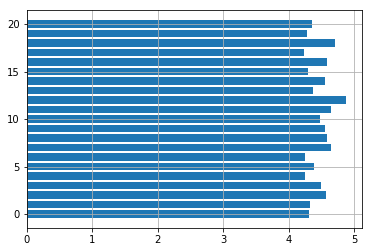

In [21]:
plt.barh(range(embeddings.shape[0]), np.sum(np.abs(embeddings), 1))
plt.grid(True)

In [122]:
embeddings.shape

(22, 256)

In [123]:
embeddings[:,0].sum()

2.0444486

In [176]:
embeddings = np.delete(embeddings, -1, axis=0)

In [125]:
embeddings.shape

(21, 256)

In [198]:
model

Loop (
  (encoder): Encoder (
    (lut_p): Embedding(44, 256, max_norm=1.0)
    (lut_s): Embedding(21, 256, max_norm=1.0)
  )
  (decoder): Decoder (
    (attn): GravesAttention (
      (sm): Softmax ()
      (N_a): Sequential (
        (0): Linear (6380 -> 638)
        (1): ReLU ()
        (2): Linear (638 -> 30)
      )
    )
    (N_o): Sequential (
      (0): Linear (6380 -> 638)
      (1): ReLU ()
      (2): Linear (638 -> 256)
    )
    (output): Linear (256 -> 63)
    (N_u): Sequential (
      (0): Linear (6380 -> 638)
      (1): ReLU ()
      (2): Linear (638 -> 319)
    )
    (F_u): Linear (256 -> 256)
    (F_o): Linear (256 -> 256)
  )
)

In [22]:
genders = speaker_info_loop['gender']
m_idx = genders == 'M'
f_idx = genders == 'F'
input_tsne = [m for i, m in enumerate(embeddings) if i in m_idx or i in f_idx]

In [23]:
m_idx

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9      True
10    False
11    False
12    False
13    False
14     True
15    False
16    False
17     True
18     True
19    False
20    False
Name: gender, dtype: bool

In [24]:
len(input_tsne)

21

In [25]:
input_tsne[2].shape

(64,)

In [26]:
input_tsne = [m for i, m in enumerate(embeddings)]

In [27]:
len(input_tsne[0])

64

In [28]:
print(embeddings.shape)
tsne = TSNE(n_components=2)
S_tsne = tsne.fit_transform(embeddings)

print(S_tsne.shape)

(21, 64)
(21, 2)


In [29]:
S_tsne[f_idx,0]

array([ -35.50378036,  155.37445068,  -92.49354553,   30.04406929,
         23.47151947,  -68.53360748,   80.60135651, -137.35650635,
        -92.0561676 ,   83.73049164,  150.73893738,  -30.70377922,
         42.48396301,  107.8965683 , -160.53491211, -110.75747681,
         87.64492035], dtype=float32)

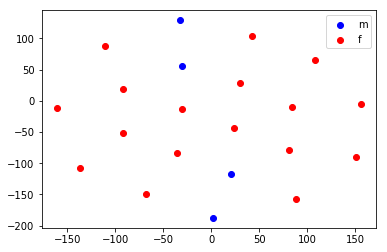

In [30]:
m_plot = plt.scatter(S_tsne[m_idx, 0], S_tsne[m_idx, 1], c='b', label='m')
f_plot = plt.scatter(S_tsne[f_idx, 0], S_tsne[f_idx, 1], c='r', label='f')
leg = plt.legend(handles=[m_plot, f_plot])

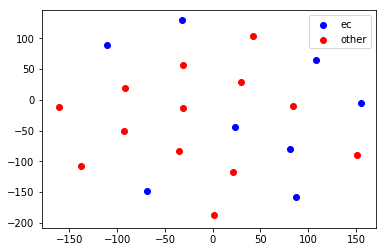

In [31]:
m_plot = plt.scatter(S_tsne[idx_east_coast, 0], S_tsne[idx_east_coast, 1], c='b', label='ec')
f_plot = plt.scatter(S_tsne[idx_other, 0], S_tsne[idx_other, 1], c='r', label='other')
leg = plt.legend(handles=[m_plot, f_plot])

In [32]:
from sklearn.decomposition import PCA

In [33]:
pca = PCA(n_components=2)
x2d = pca.fit_transform(embeddings)

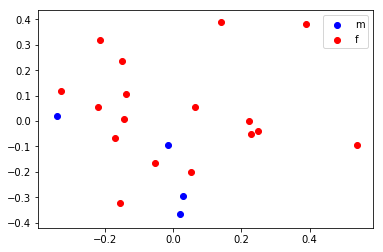

In [34]:
m_plot = plt.scatter(x2d[m_idx, 0], x2d[m_idx, 1], c='b', label='m')
f_plot = plt.scatter(x2d[f_idx, 0], x2d[f_idx, 1], c='r', label='f')
leg = plt.legend(handles=[m_plot, f_plot])

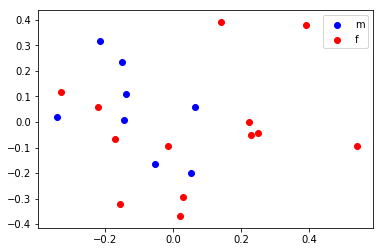

In [35]:
m_plot = plt.scatter(x2d[idx_east_coast, 0], x2d[idx_east_coast, 1], c='b', label='m')
f_plot = plt.scatter(x2d[idx_other, 0], x2d[idx_other, 1], c='r', label='f')
leg = plt.legend(handles=[m_plot, f_plot])

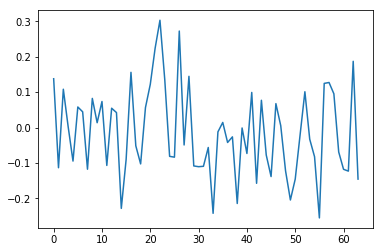

In [36]:
plt.plot(pca.components_[0, :])

In [37]:
pca.explained_variance_ratio_

array([ 0.11748701,  0.09909551], dtype=float32)